In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import seaborn as sns
sns.set_style("darkgrid")
from scipy.stats import zscore

In [2]:
# phenotypes and labels
phenos=['INI21001','HC326','HC328']
nameos=['Body Mass Index (BMI)','Myocardial Infarction (MI)','Gout']

# load degas data
proj_dir='/oak/stanford/groups/mrivas/projects/degas-risk/'
z=np.load(proj_dir+'datasets/train/v2/tsvd/all_beta_center_p1e-06_20200506_500PCs.npz', allow_pickle=True)
cprs=pd.read_table(proj_dir+'scorefiles/v2/all_beta_center_p1e-06_20200506_500PCs.sscore', 
                   sep='\s+', index_col='#IID')
cprs.iloc[:,:10].head()

,NMISS_ALLELE_CT,DENOM,SCORE1_SUM,SCORE2_SUM,SCORE3_SUM,SCORE4_SUM,SCORE5_SUM,SCORE6_SUM,SCORE7_SUM,SCORE8_SUM
#IID,,,,,,,,,,
-1,355196,372754,-374.926,368.9690,-196.4650,-97.1283,-2.21344,-753.529,19.1898,-167.3870
-2,356484,372754,2081.050,124.7970,58.0359,-49.8936,68.32710,3415.330,-30.1381,24.4475
-3,356188,372754,462.962,-621.6750,-766.0030,-89.6043,263.50600,140.336,-145.2270,-56.4664
-4,356568,372754,1209.550,265.7590,202.5610,-63.9855,-463.20400,1981.050,76.8572,-160.4220
-5,354946,372754,-262.183,36.7316,933.4940,-90.8465,-72.29410,-198.796,-56.8297,-135.6170


In [3]:
# load (d)PRS info
dprs={phe:cprs.iloc[:,2:].dot(z['V'][np.where(z['label_phe_code'] == phe),:].flatten()) for phe in phenos}
prs={phe:pd.read_csv(proj_dir+'PRS/train/v2/all_beta_center_p1e-06_20200506/{}_PRS.profile'.format(phe),
                       sep='\s+', usecols=['IID','SCORESUM'], index_col='IID') for phe in phenos}
prs_df={} # for later

In [4]:
# consider test set individuals
test=pd.read_csv(proj_dir+'population-split/ukb24983_white_british_test.phe', sep='\s+').iloc[:,0]

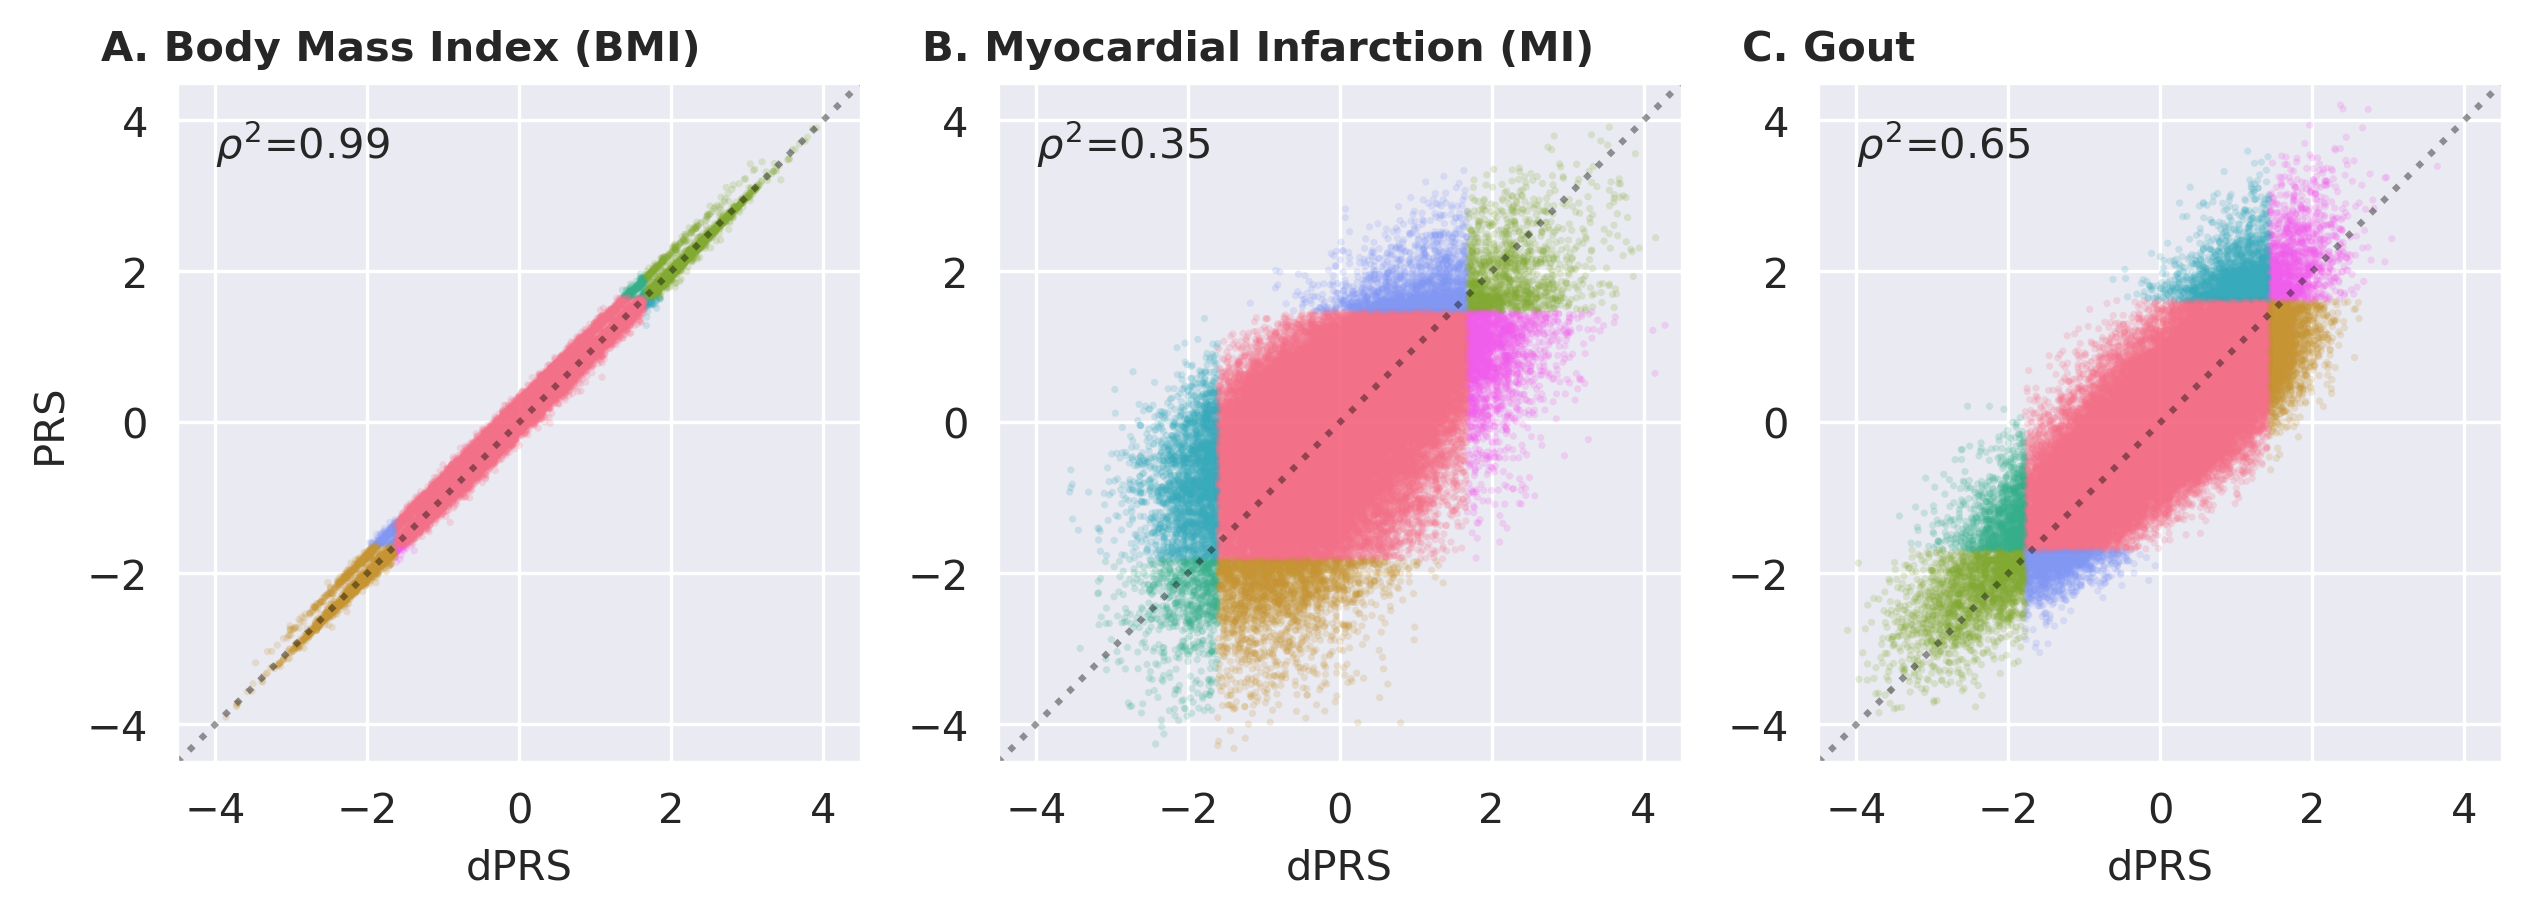

In [14]:
# make plot
fig=plt.figure(figsize=(10,3), dpi=300)
for i,phe in enumerate(phenos):
    ax=plt.subplot(1,3,1+i)
    df=pd.DataFrame(dprs[phe]).merge(prs[phe], left_index=True, right_index=True).loc[test,:]
    df.columns=['dPRS','PRS']
    df['PRS']=zscore(df['PRS'])
    df['dPRS']=zscore(df['dPRS'])
    p5,p95=df['PRS'].quantile(0.95), df['PRS'].quantile(0.05)
    d5,d95=df['dPRS'].quantile(0.95), df['dPRS'].quantile(0.05)  
    df['rank']=df.apply(lambda x:'{0}_{1}'.format('T5' if x['dPRS'] > d5 else 'B5' if x['dPRS'] < d95 else 'M',
                                                   'T5' if x['PRS'] > p5 else 'B5' if x['PRS'] < p95 else 'M'),
                        axis=1)
    prs_df[phe]=df
    sns.scatterplot(x='dPRS', y='PRS', hue='rank', data=df, s=3, alpha=0.2, linewidth=0, legend=None, ax=ax)
    ax.set_xlim(-4.5,4.5);
    ax.set_ylim(ax.get_xlim());
    ax.plot(ax.get_xlim(), ax.get_ylim(), 'k:', alpha=0.4)
    if i>0: 
        ax.set_ylabel('')
    plt.text(-5.5, 4.8, chr(ord('A')+i)+'. '+nameos[i], weight='bold')
    plt.text(-4, 3.5, r'$\rho^2$'+'={:.2f}'.format(df.corr(method='spearman').iloc[0,1]**2))
plt.show()    

In [15]:
# load phenotype data
phe_df=pd.read_csv(proj_dir+'master.20200420.phe', sep='\t', index_col=['IID'],
                    usecols=['IID']+phenos)

In [22]:
# make Table S2
for phe in phenos:
    df=prs_df[phe].merge(phe_df, left_index=True, right_index=True).replace(-9, np.nan).dropna()
    print(phe)
    if phe=='INI21001':
        print(df['rank'].value_counts())
    else:
        print(df.apply(lambda x:x['rank']+'_'+str(x[phe]), axis=1).value_counts())

INI21001
M_M      60059
T5_T5     3165
B5_B5     3116
B5_M       251
M_B5       251
M_T5       197
T5_M       196
Name: rank, dtype: int64
HC326
M_M_1.0      53635
B5_M_1.0      2468
M_B5_1.0      2447
M_M_2.0       2289
M_T5_1.0      1936
T5_M_1.0      1934
T5_T5_1.0     1227
B5_B5_1.0      791
T5_M_2.0       109
M_T5_2.0       105
M_B5_2.0       100
T5_T5_2.0       91
B5_M_2.0        82
B5_B5_2.0       21
dtype: int64
HC328
M_M_1.0      56013
B5_B5_1.0     2064
T5_M_1.0      1936
M_T5_1.0      1923
M_B5_1.0      1282
B5_M_1.0      1281
T5_T5_1.0     1257
M_M_2.0       1178
M_T5_2.0       101
T5_M_2.0        88
T5_T5_2.0       87
B5_M_2.0        12
M_B5_2.0        11
B5_B5_2.0        2
dtype: int64
